# Semantic Segmentation

*Follows general structure of [fast.ai notebook](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-camvid.ipynb)*

In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
import PIL

from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

## Load Data

We use the [Berkely Deep Drive Dataset](https://bdd-data.berkeley.edu/) which contains a rich labeled dataset for image segmentation in diverse conditions (weather, city, reference car…).

In [3]:
path_data = Path('./data/bdd100k/seg')
path_lbl = path_data/'labels'
path_img = path_data/'images'

In [4]:
fnames = get_image_files(path_img, recurse = True)
fnames[:3]

[PosixPath('data/bdd100k/seg/images/train/00e9be89-00001295.jpg'),
 PosixPath('data/bdd100k/seg/images/train/051a273b-48b86bf6.jpg'),
 PosixPath('data/bdd100k/seg/images/train/b0409282-a0efc7da.jpg')]

In [5]:
lbl_names = get_image_files(path_lbl, recurse = True)
lbl_names[:3]

[PosixPath('data/bdd100k/seg/labels/train/0b4c8138-adfd774c_train_id.png'),
 PosixPath('data/bdd100k/seg/labels/train/85774b5c-8b5d8894_train_id.png'),
 PosixPath('data/bdd100k/seg/labels/train/327e2f77-99160976_train_id.png')]

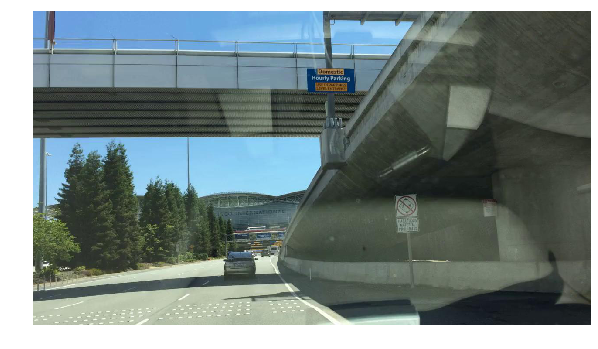

In [6]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(10,10))

In [7]:
get_y_fn = lambda x: path_lbl/x.parts[-2]/f'{x.stem}_train_id.png'

img_f, get_y_fn(img_f)

(PosixPath('data/bdd100k/seg/images/train/00e9be89-00001295.jpg'),
 PosixPath('data/bdd100k/seg/labels/train/00e9be89-00001295_train_id.png'))

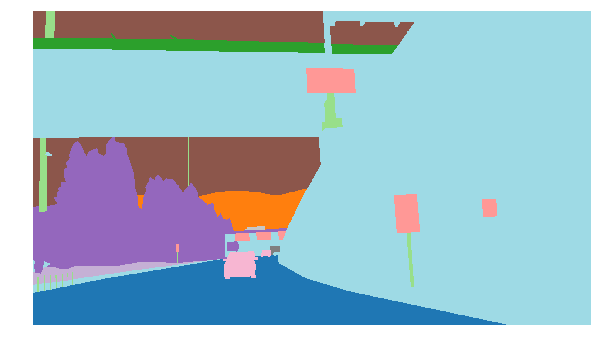

In [8]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(10,10), alpha=1)

In [9]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([ 720, 1280]), tensor([[[10, 10, 10,  ..., 19, 19, 19],
          [10, 10, 10,  ..., 19, 19, 19],
          [10, 10, 10,  ..., 19, 19, 19],
          ...,
          [ 0,  0,  0,  ..., 19, 19, 19],
          [ 0,  0,  0,  ..., 19, 19, 19],
          [ 0,  0,  0,  ..., 19, 19, 19]]]))

## Datasets

In [10]:
size = 256
bs = 8

In [11]:
# Classes extracted from dataset source code
# -> https://github.com/ucbdrive/bdd-data/blob/master/bdd_data/label.py

segmentation_classes = ['road',
                       'sidewalk',
                       'building',
                       'wall',
                       'fence',
                       'pole',
                       'traffic light',
                       'traffic sign',
                       'vegetation',
                       'terrain',
                       'sky',
                       'person',
                       'rider',
                       'car',
                       'truck',
                       'bus',
                       'train',
                       'motorcycle',
                       'bicycle',
                        'void']

In [12]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_folder(train='train', valid='val')
       .label_from_func(get_y_fn, classes = segmentation_classes))

In [13]:
src

LabelLists;

Train: LabelList (7000 items)
x: SegmentationItemList
Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280)
y: SegmentationLabelList
ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280)
Path: data/bdd100k/seg/images;

Valid: LabelList (1000 items)
x: SegmentationItemList
Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280)
y: SegmentationLabelList
ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280)
Path: data/bdd100k/seg/images;

Test: None

In [14]:
src.train.y.loss_func

FlattenedLoss of CrossEntropyLoss()

In [15]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

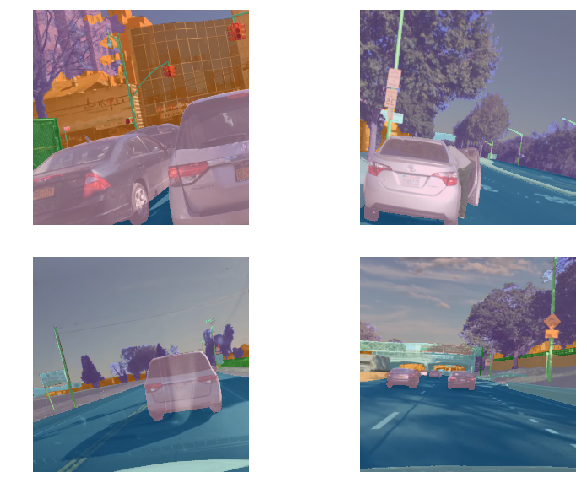

In [16]:
data.show_batch(2, figsize=(10,7))

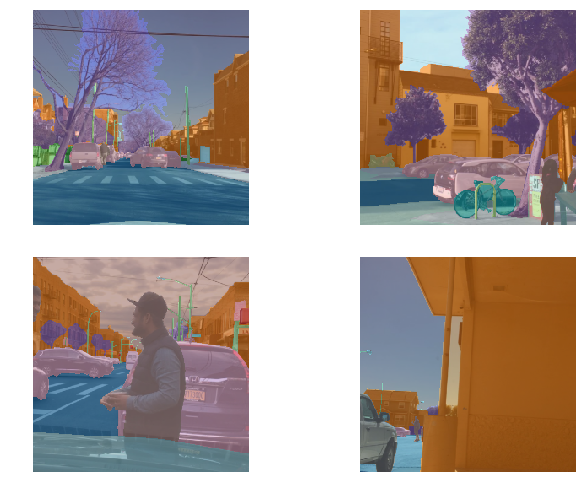

In [17]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [18]:
name2id = {v:k for k,v in enumerate(segmentation_classes)}
void_code = name2id['void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [19]:
metrics=acc_camvid
# metrics=accuracy

In [20]:
wd=1e-4

In [21]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


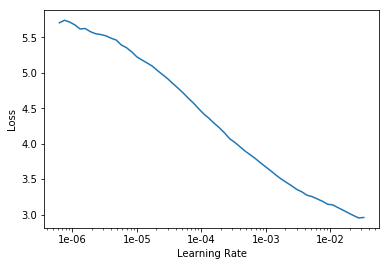

In [22]:
lr_find(learn)
learn.recorder.plot()

In [23]:
lr=3e-3

In [24]:
learn.fit_one_cycle(3, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.763306,0.663291,0.829105,04:20
1,0.740060,0.623693,0.830253,04:19
2,0.635358,0.477396,0.874355,04:16


In [32]:
x = learn.save('stage-1')

In [34]:
learn.path

PosixPath('data/bdd100k/seg/images')

In [35]:
learn.model

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum

In [26]:
learn.load('stage-1');

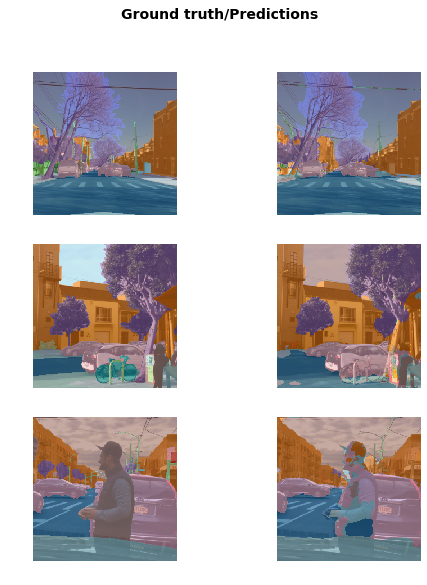

In [27]:
learn.show_results(rows=3, figsize=(8,9))

In [28]:
learn.unfreeze()

In [29]:
lrs = slice(lr/400,lr/4)

In [30]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.616574,0.460709,0.876218,04:33


KeyboardInterrupt: 

In [ ]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
#learn.destroy() # uncomment once 1.0.46 is out

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('stage-2');

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

## fin